# Importing, Cleaning, and Exploring USDA Fruit Yearbook Time Series Data

* Data and description sourced from the [United States Department of Agriculture](https://www.ers.usda.gov/data-products/fruit-and-tree-nut-data/fruit-and-tree-nut-yearbook-tables/)

* The USDA Fruit and Tree Nut Yearbook tables contains almost four decades of time-series data for U.S. bearing acreage, production, prices, etc. for a variety of Fruit and Nut Tree crops.

* Here we import data from a collection of Fruit Tree Yearbook tables that look at bearing acreage, and yield per acre, for a time series ranging from 1980 through 2018.

* The formatting of the data in the CSV files is a bit messy, so we utilize a custom helper function to reformat the data so that it can be put in a form that is more conducive to plotting and time series analysis, and is able to be broken down by both State and crop.

In [1]:
import csv
import math
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

%matplotlib inline

# a function that takes in the filename of a csv file exported from a USDA Fruit Yearbook table
# returns a 2D array containing the values for bearing acreage and yield per acre, broken down by state
# assumes that the yearbook table is one of the bearing acreage and yield per acre tables, broken down by state
def readCSV(filename):
    data = []
    with open(filename) as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            data.append(row)
    
    return data


# read the yearbook tables for each of the three citrus crops                
data1 = readCSV('FruitYearbookCitrusFruit_CTables_Grapefruit.csv')
data2 = readCSV('FruitYearbookCitrusFruit_CTables_Lemons.csv')
data3 = readCSV('FruitYearbookCitrusFruit_CTables_Oranges.csv')


# helper function that takes in the data read from one of the Fruit Yearbook tables
# produces a cleaned up version of the table
# each row in the cleaned up data table has a season, state, bearing acreage, yield per acre, and potentially production
def getCleanYearbookData(data, start_row, end_row):
    
    # extract the states represented in this yearbook
    states = [string for string in data[1] if string != '' and string != ' ']
    
    # used to determine which state partition a read datum is placed into
    divisor = len(data[start_row]) // len(states)
    
    partitioned_rows = []
    
    for i in range(start_row, end_row + 1):    
        row = data[i]   
        if row[0] != '':
            year = row[0]
            
            # each row in the cleaned data set has a year (season), state, and the recorded metrics
            partitioned_row = [[year, state] for state in states]
            
            col_index = 0
            
            for col in row:         
                if col_index != 0 and col != '' and col != ' ':  
                    val_to_add = 0.0
                    
                    if col.find(',') != -1:
                        val_to_add = int(col.replace(',', ''))
                    elif col.find('na') == -1:  
                        val_to_add = float(col)
                                    
                    partitioned_row[math.ceil(col_index / divisor) - 1].append(val_to_add)
                
                col_index += 1
            
            partitioned_rows += partitioned_row
    
    return partitioned_rows

# get cleaned up versions of the data for each of the three crops
cleaned_data_grapefruit = getCleanYearbookData(data1, 8, 50)
cleaned_data_lemons = getCleanYearbookData(data2, 8, 50)
cleaned_data_oranges = getCleanYearbookData(data3, 8, 50)


In [5]:
from enum import Enum

# enum type for specifying the type of time series plot to be generated
class YearbookPlotType(Enum):
    YIELD_PER_ACRE = 1
    BEARING_ACREAGE = 2
    PRODUCTION = 3

# helper function that takes in one of the cleaned_datasets, and a string labelling the crop
# produces time series plots of yield per acre for the given crop accross all recorded states
def plot_time_series(dataset, crop, plot_type = YearbookPlotType.YIELD_PER_ACRE):
    
    states = list(set([row[1] for row in dataset]))
    
    columns = 2
    rows = int(math.ceil(len(states) / columns))
    curr_subplot = 1
    
    plt.rcParams['figure.figsize'] = (20, 10)
    
    for state in states:
        
        state_dataset = [row for row in dataset if row[1] == state]
        
        state_metric = []
        color_string = ''
        ylabel_string = ''
        
        if plot_type == YearbookPlotType.YIELD_PER_ACRE:
            state_metric += [row[3] for row in state_dataset]
            color_string += 'r-o'
            ylabel_string += 'Yield per Acre (Short tons)'
        elif plot_type == YearbookPlotType.BEARING_ACREAGE:
            state_metric += [row[2] for row in state_dataset]
            color_string += 'b-o'
            ylabel_string += 'Bearing Acreage (1k acres)'
        else:
            if crop != 'Lemons':
                state_metric += [row[3] * row[2] for row in state_dataset]
            else:
                state_metric += [row[4] for row in state_dataset]
            color_string += 'g-o'
            ylabel_string += 'Production (1k short tons)'
        
        year_strings = [row[0] for row in state_dataset]
        
        years = [int(year_string[:5]) for year_string in year_strings]
        
        title_string = ''
        
        if state == 'United States':
            title_string += crop + ' in the ' + state
        else:
            title_string += crop + ' in the State of ' + state
        
        plt.subplot(rows, columns, curr_subplot)
        plt.plot(years, state_metric, color_string)
        plt.title(title_string)
        plt.xlabel('Start Year of Season')
        plt.ylabel(ylabel_string)
        curr_subplot += 1
    
    plt.tight_layout()
    plt.show()

# Plotting Time Series for Grapefruit By State

- Here we generate time series plots of Yield per Acre, Bearing Acreage, and Production (YPA * BA) for Grapefruit
- We see that while Grapefruit production has remained fairly stable in the state of Texas over the past 18 years, production has declined significantly in other states.
- In the state of California, while yield per acre has remained in a fairly stable oscillation since the year 2000, bearing acreage has been at an historic low since 2005, after having declined by roughly 40% between the years 2000 and 2005, contributing to a relatively low overall production by historic standards.
- In the state of Florida, a roughly two-thirds reduction in overall production is evident between the 2003/2004 and 2004/2005 seasons, due to three hurricanes and a tropical storm having passed through the state in the months of August and September, as well as the overall destructive [2004 Atlantic Hurricane Season](https://en.wikipedia.org/wiki/2004_Atlantic_hurricane_season). 
- Whilst a slight recovery of Florida Grapefruit production is evident between the years of 2004 and 2006, grapefruit production has witnessed a steady decline between 2006 and 2017, largely due to crop destruction by [citrus greening disease](https://www.floridafarmbureau.org/hope-for-floridas-declining-citrus-industry/).
- In the state of Arizona, Grapefruit production underwent a steady decline between 1991 and 2009, until finally dropping to such low levels that the USDA has ceased recording census information for this crop since 2009.
- [Decline in overall grapefruit production in Arizona](https://tucson.com/business/local/az-citrus-industry-hangs-on-amid-long-term-decline/article_13e6e4d8-8070-52bf-9ab3-eed24249e558.html) is due both to a reduction in bearing acreage, as well as damage by pests such as the [Asian citrus psyllid](http://californiacitrusthreat.org/pest-disease), which spreads citrus greening disease.
- Bearing acreage in the state of Texas has two steep drops, one after 1983, and another after 1989, both due to [highly destructive December freezes](https://aggie-horticulture.tamu.edu/citrus/l2319.htm)

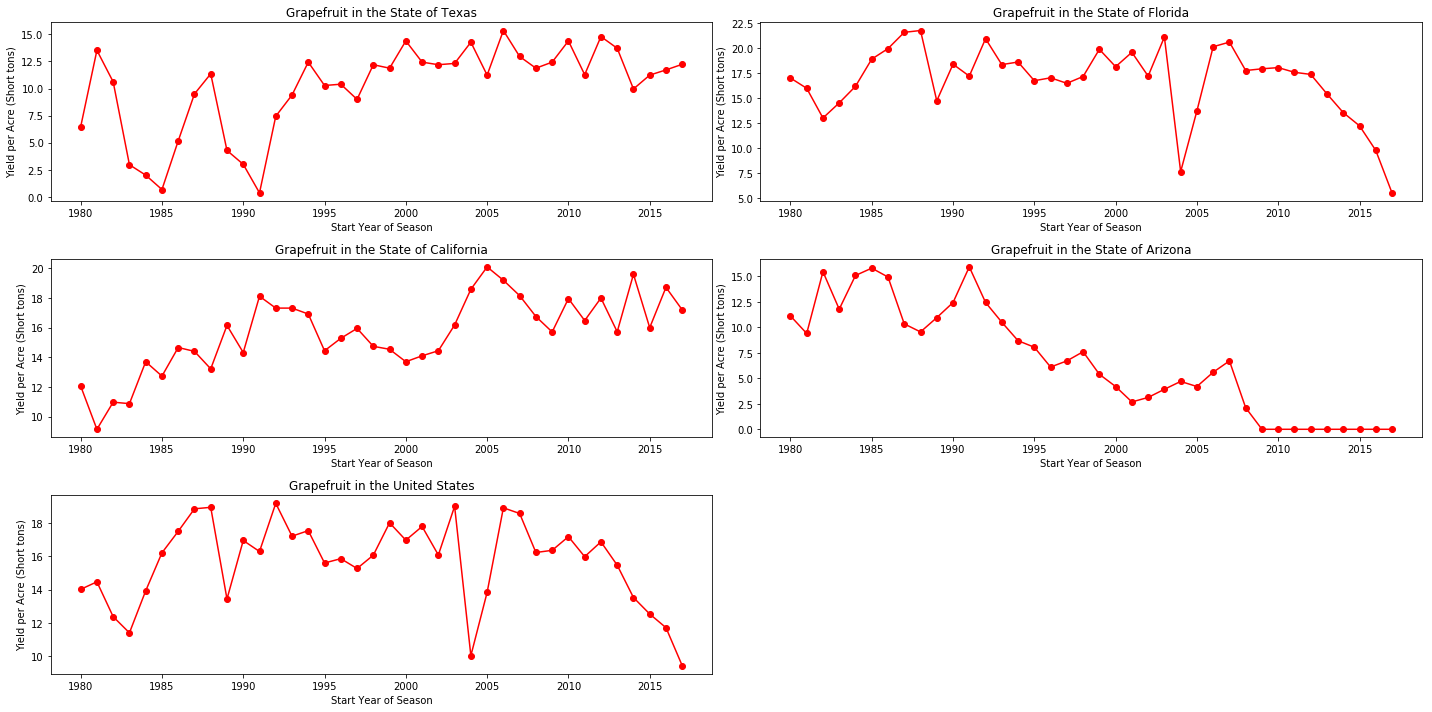

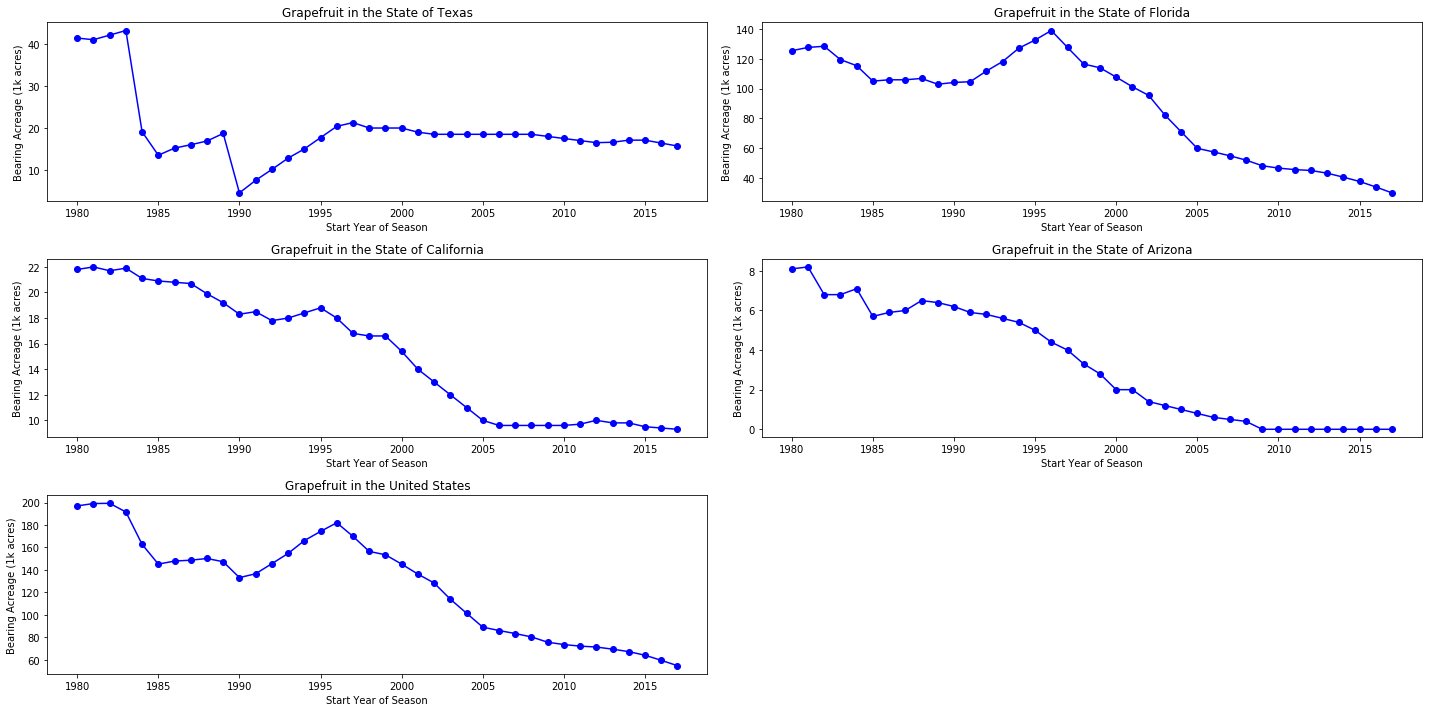

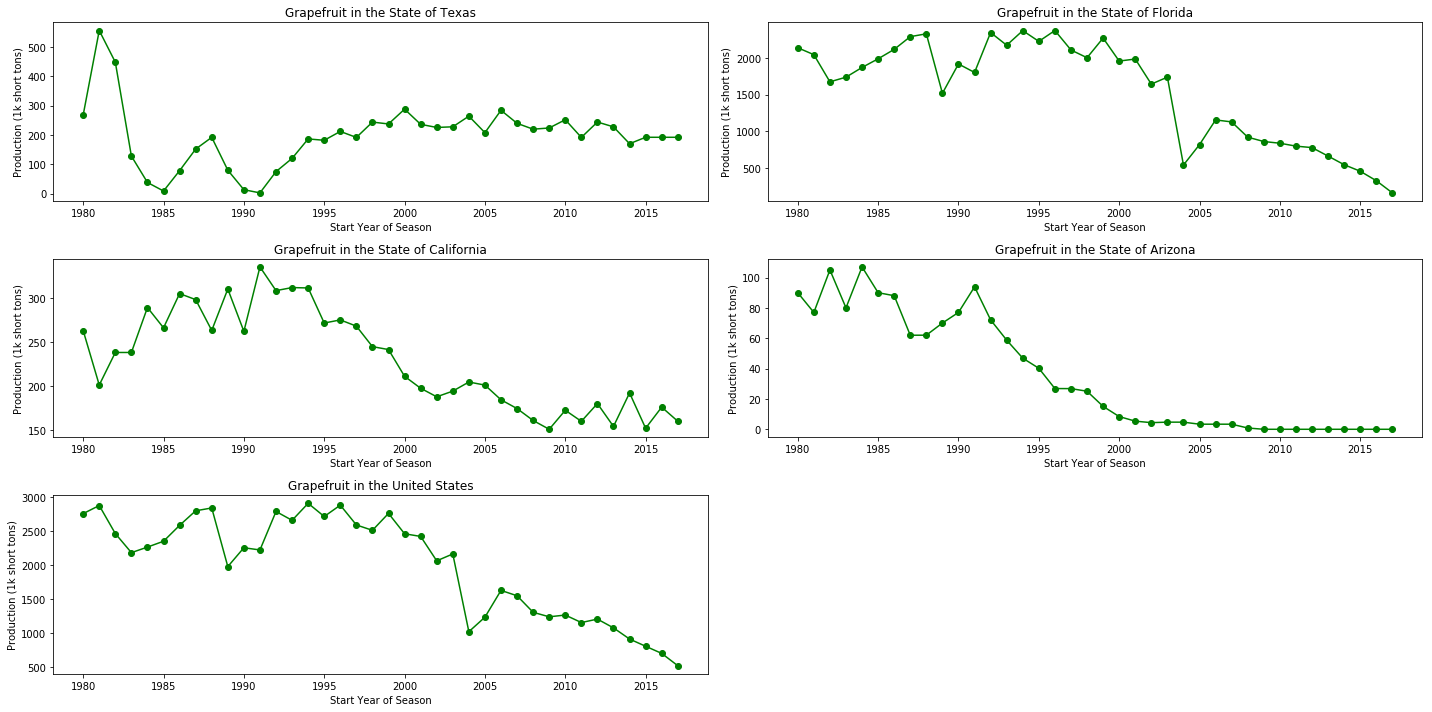

In [6]:
plot_time_series(cleaned_data_grapefruit, 'Grapefruit', YearbookPlotType.YIELD_PER_ACRE)
plot_time_series(cleaned_data_grapefruit, 'Grapefruit', YearbookPlotType.BEARING_ACREAGE)
plot_time_series(cleaned_data_grapefruit, 'Grapefruit', YearbookPlotType.PRODUCTION)

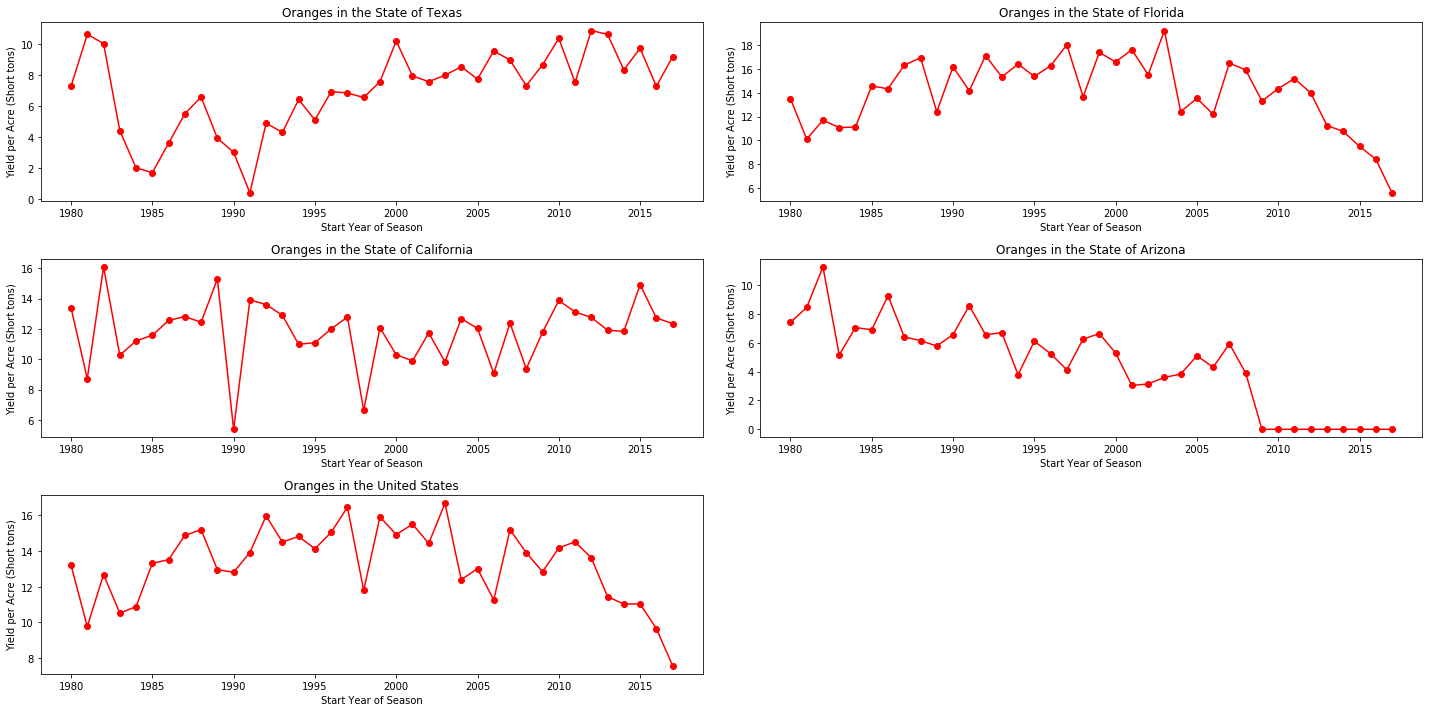

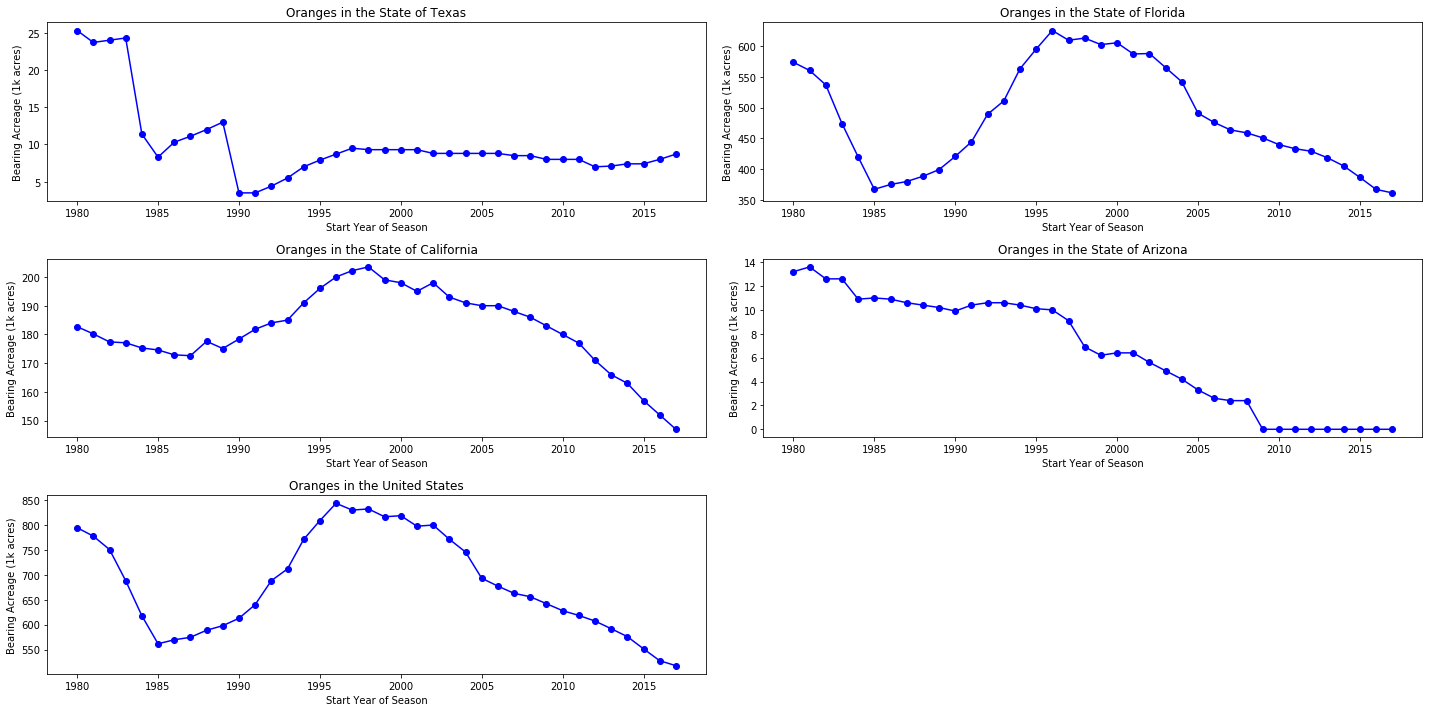

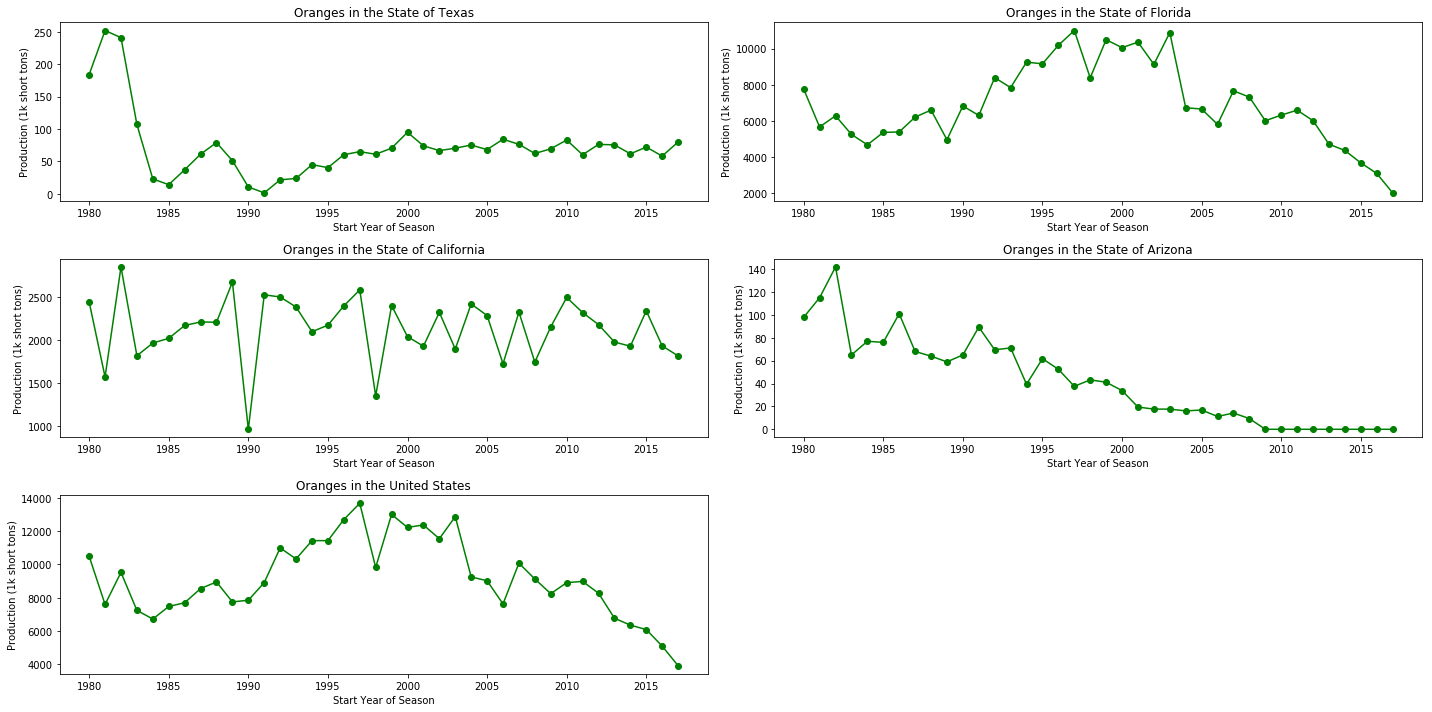

In [7]:
plot_time_series(cleaned_data_oranges, 'Oranges', YearbookPlotType.YIELD_PER_ACRE)
plot_time_series(cleaned_data_oranges, 'Oranges', YearbookPlotType.BEARING_ACREAGE)
plot_time_series(cleaned_data_oranges, 'Oranges', YearbookPlotType.PRODUCTION)

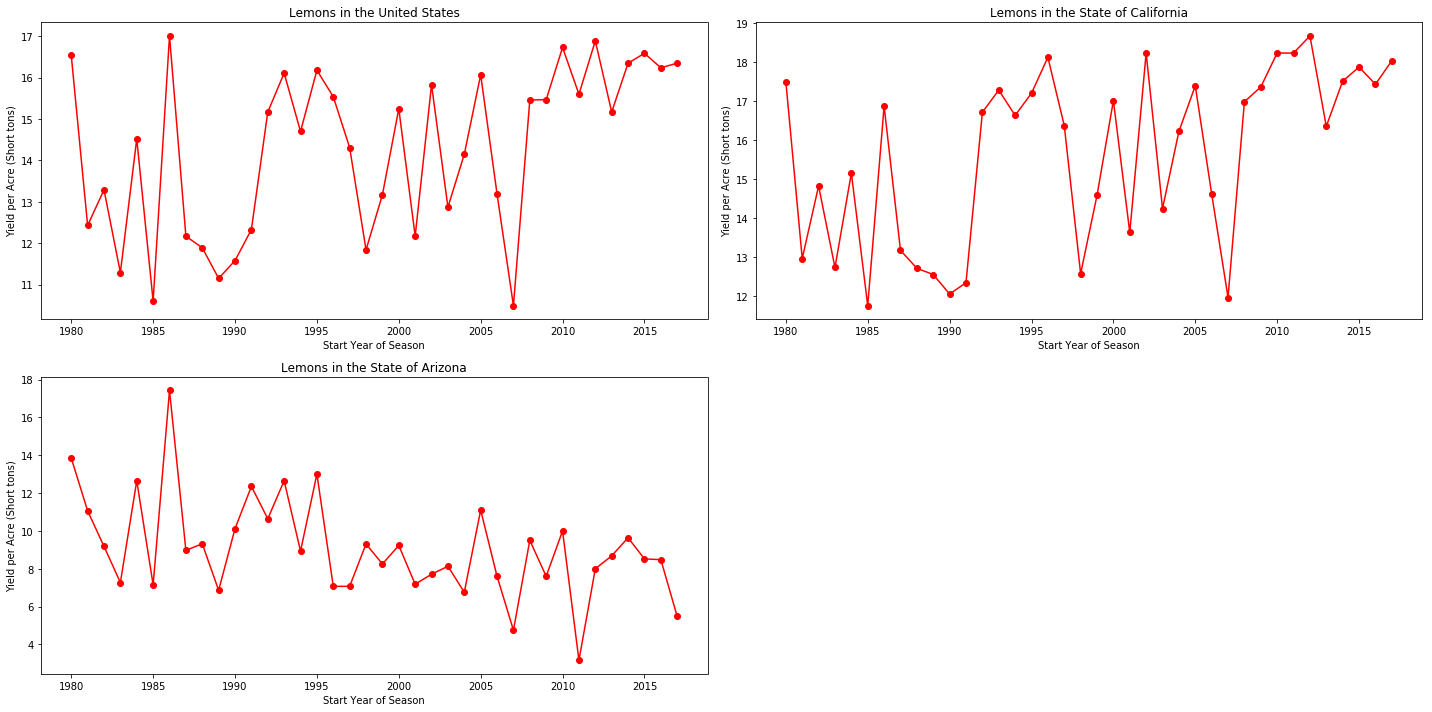

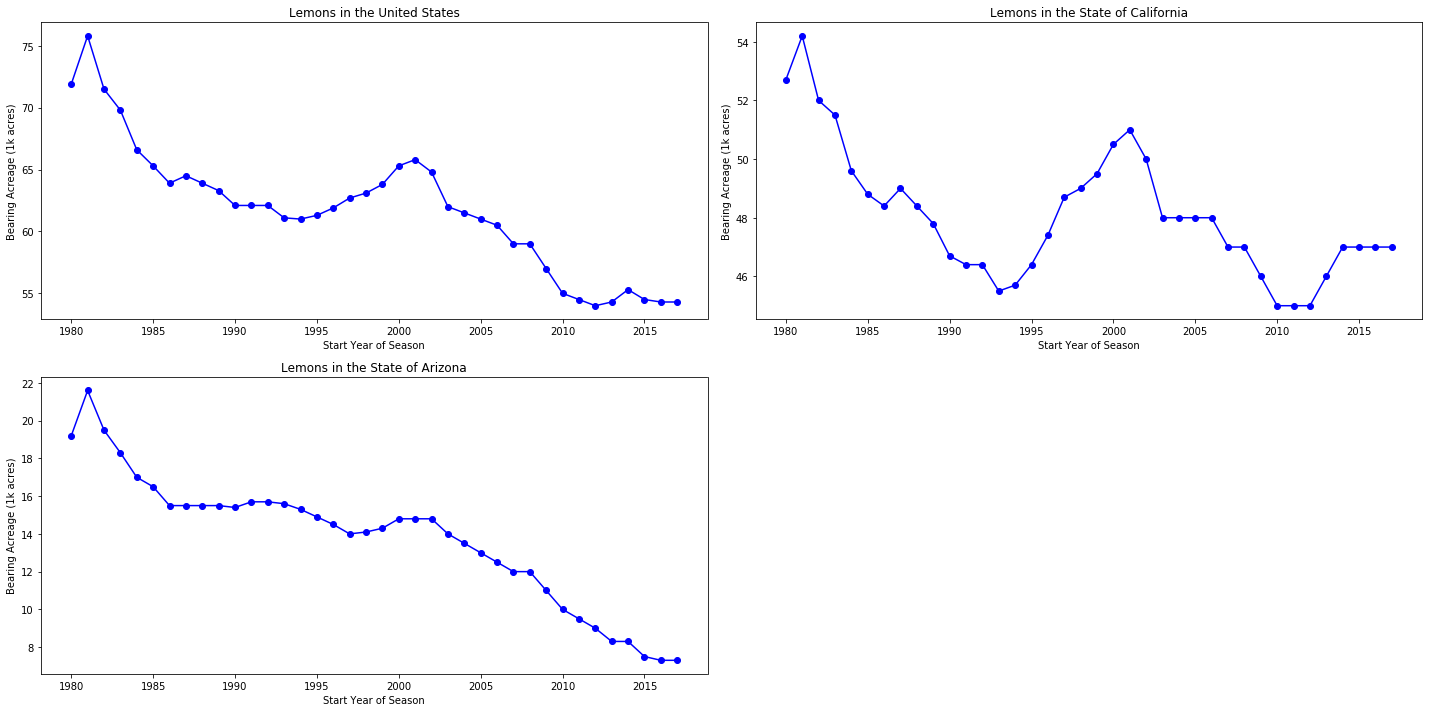

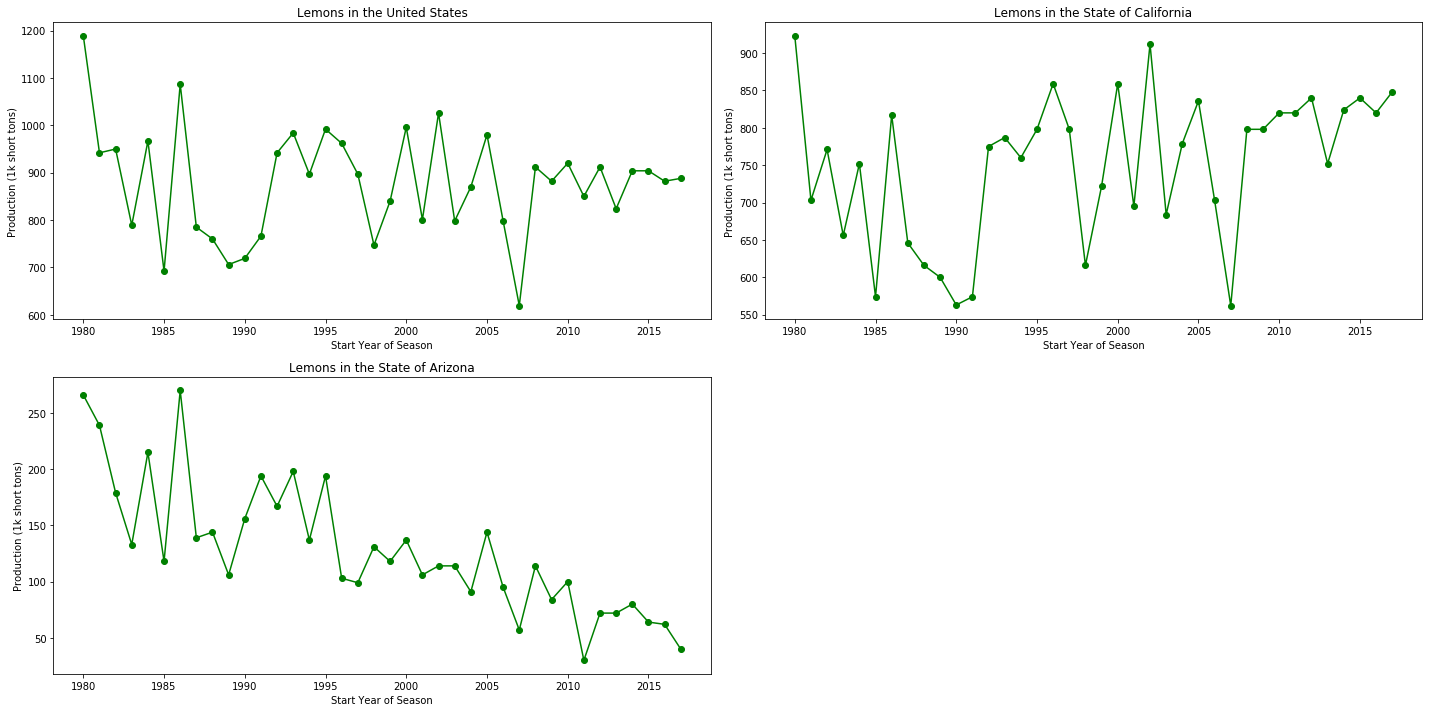

In [8]:
plot_time_series(cleaned_data_lemons, 'Lemons', YearbookPlotType.YIELD_PER_ACRE)
plot_time_series(cleaned_data_lemons, 'Lemons', YearbookPlotType.BEARING_ACREAGE)
plot_time_series(cleaned_data_lemons, 'Lemons', YearbookPlotType.PRODUCTION)